# Motion Compensation et Compression Vidéo

### Importation des bibliothèques nécessaires

In [1]:
#!pip install matplotlib
#!pip install numpy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from skimage.metrics import mean_squared_error

### Visualisation des images données à l'étude

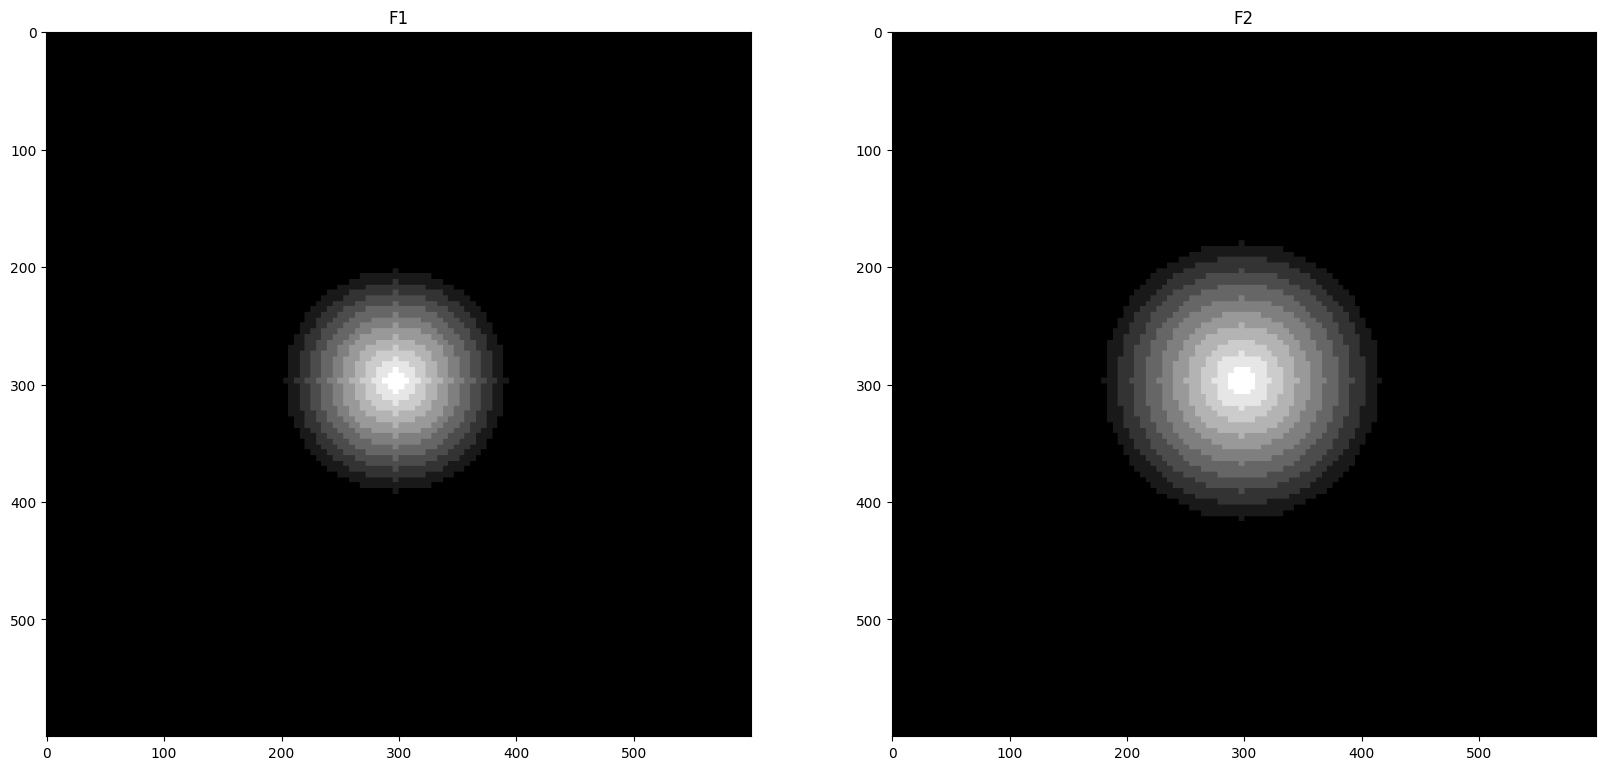

In [2]:
# Load images
img1 = mpimg.imread('F1.png').mean(axis=2)
img2 = mpimg.imread('F2.png').mean(axis=2)

# Display images
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('F1')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title('F2')

plt.show()

### (A) Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.

### Estimation de Mouvement - Méthode Block Matching (BMA)

Cette méthode consiste à diviser l'image en blocs et à trouver le déplacement optimal pour chaque bloc en minimisant une fonction de coût.

### Hypothèse et Démarche

La méthode Block Matching repose sur l'hypothèse que le déplacement des blocs d'image entre deux frames successives peut être approximé par la recherche du bloc correspondant dans une fenêtre de recherche dans la deuxième image.

Soit $B(i,j)$ un bloc de l'image $\psi_{2}$ centré en $(i,j)$. Pour chaque bloc $B$ dans l'image $\psi_{1}$, nous cherchons le bloc correspondant $B′$ dans $\psi_{1}$​ tel que l'erreur $E$ soit minime:
$$E=minimize∑_{(x,y)∈B}∣\psi_{1}(x+u,y+v)−\psi_{2}(x,y)∣$$
où $u$ et $v$ sont les déplacements horizontaux et verticaux respectivement, et la somme est prise sur tous les pixels $(x,y)$ du bloc $B$.

In [3]:
def find_min_coordinates(matrix, window_size):
    min_value = float('inf')
    min_distance = float('inf')
    min_coords = None

    center = (window_size + 1, window_size + 1)

    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] < min_value:
                min_value = matrix[i][j]
                min_coords = (i, j)
                min_distance = abs(i - center[0]) + abs(j - center[1])
            elif matrix[i][j] == min_value:
                distance = abs(i - center[0]) + abs(j - center[1])
                if distance < min_distance:
                    min_coords = (i, j)
                    min_distance = distance

    return min_coords

Cette fonction divise l'image `frame1` en blocs de taille `block_size` et recherche le bloc correspondant dans `frame2` en minimisant la somme des différences absolues dans une fenêtre de recherche de taille `search_range`.

In [4]:
def block_matching(frame1, frame2, block_size=10, search_range=10):
    height, width = frame2.shape
    flow_u = np.zeros((height // block_size, width // block_size))
    flow_v = np.zeros((height // block_size, width // block_size))
    modified_blocks = np.zeros((height // block_size, width // block_size), dtype=bool)

    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            best_match = (0, 0)
            current_block = frame2[i:i+block_size, j:j+block_size]
            all_cost = np.zeros((search_range * 2 + 1, search_range * 2 + 1))

            for y in range(-search_range, search_range + 1):
                for x in range(-search_range, search_range + 1):
                    ref_i = i + y
                    ref_j = j + x

                    if 0 <= ref_i <= height - block_size and 0 <= ref_j <= width - block_size:
                        ref_block = frame1[ref_i:ref_i+block_size, ref_j:ref_j+block_size]
                        cost = np.sum(np.abs(ref_block - current_block))
                        all_cost[y + search_range, x + search_range] = cost

            #min_index = np.unravel_index(np.argmin(all_cost), all_cost.shape)
            min_index = find_min_coordinates(all_cost, search_range)

            min_cost = all_cost[min_index[0], min_index[1]]
            current_block = all_cost[search_range + 1, search_range + 1]
            best_match = (min_index[0] - search_range, min_index[1] - search_range)

            if min_cost != current_block and np.linalg.norm(best_match) > 5:
                flow_u[i // block_size, j // block_size] = best_match[1]
                flow_v[i // block_size, j // block_size] = best_match[0]
                modified_blocks[i // block_size, j // block_size] = True

    return flow_u, flow_v, modified_blocks

flow_u, flow_v, modified_blocks = block_matching(img1, img2,  block_size=20, search_range=20)

In [5]:
def visualize_block_matching(frame1, frame2, block_size=8, zoom=False, figsize=(20, 20)):
    _, ax = plt.subplots(figsize=figsize)

    ax.imshow(frame1, cmap='gray')
    ax.imshow(frame2, cmap='gray', alpha=0)

    for i in range(0, frame1.shape[0] - block_size + 1, block_size):
        for j in range(0, frame1.shape[1] - block_size + 1, block_size):
            rect = patches.Rectangle((j, i), block_size, block_size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            if modified_blocks[i // block_size, j // block_size]:
                ax.quiver(j + block_size // 2, i + block_size // 2, flow_u[i // block_size, j // block_size],
                           flow_v[i // block_size, j // block_size], color='b', angles='xy', scale_units='xy', scale=1)

    if zoom:
        plt.xlim(150, 450)
        plt.ylim(150, 450)

    plt.title("Optical Flow (Block Matching)")
    plt.show()

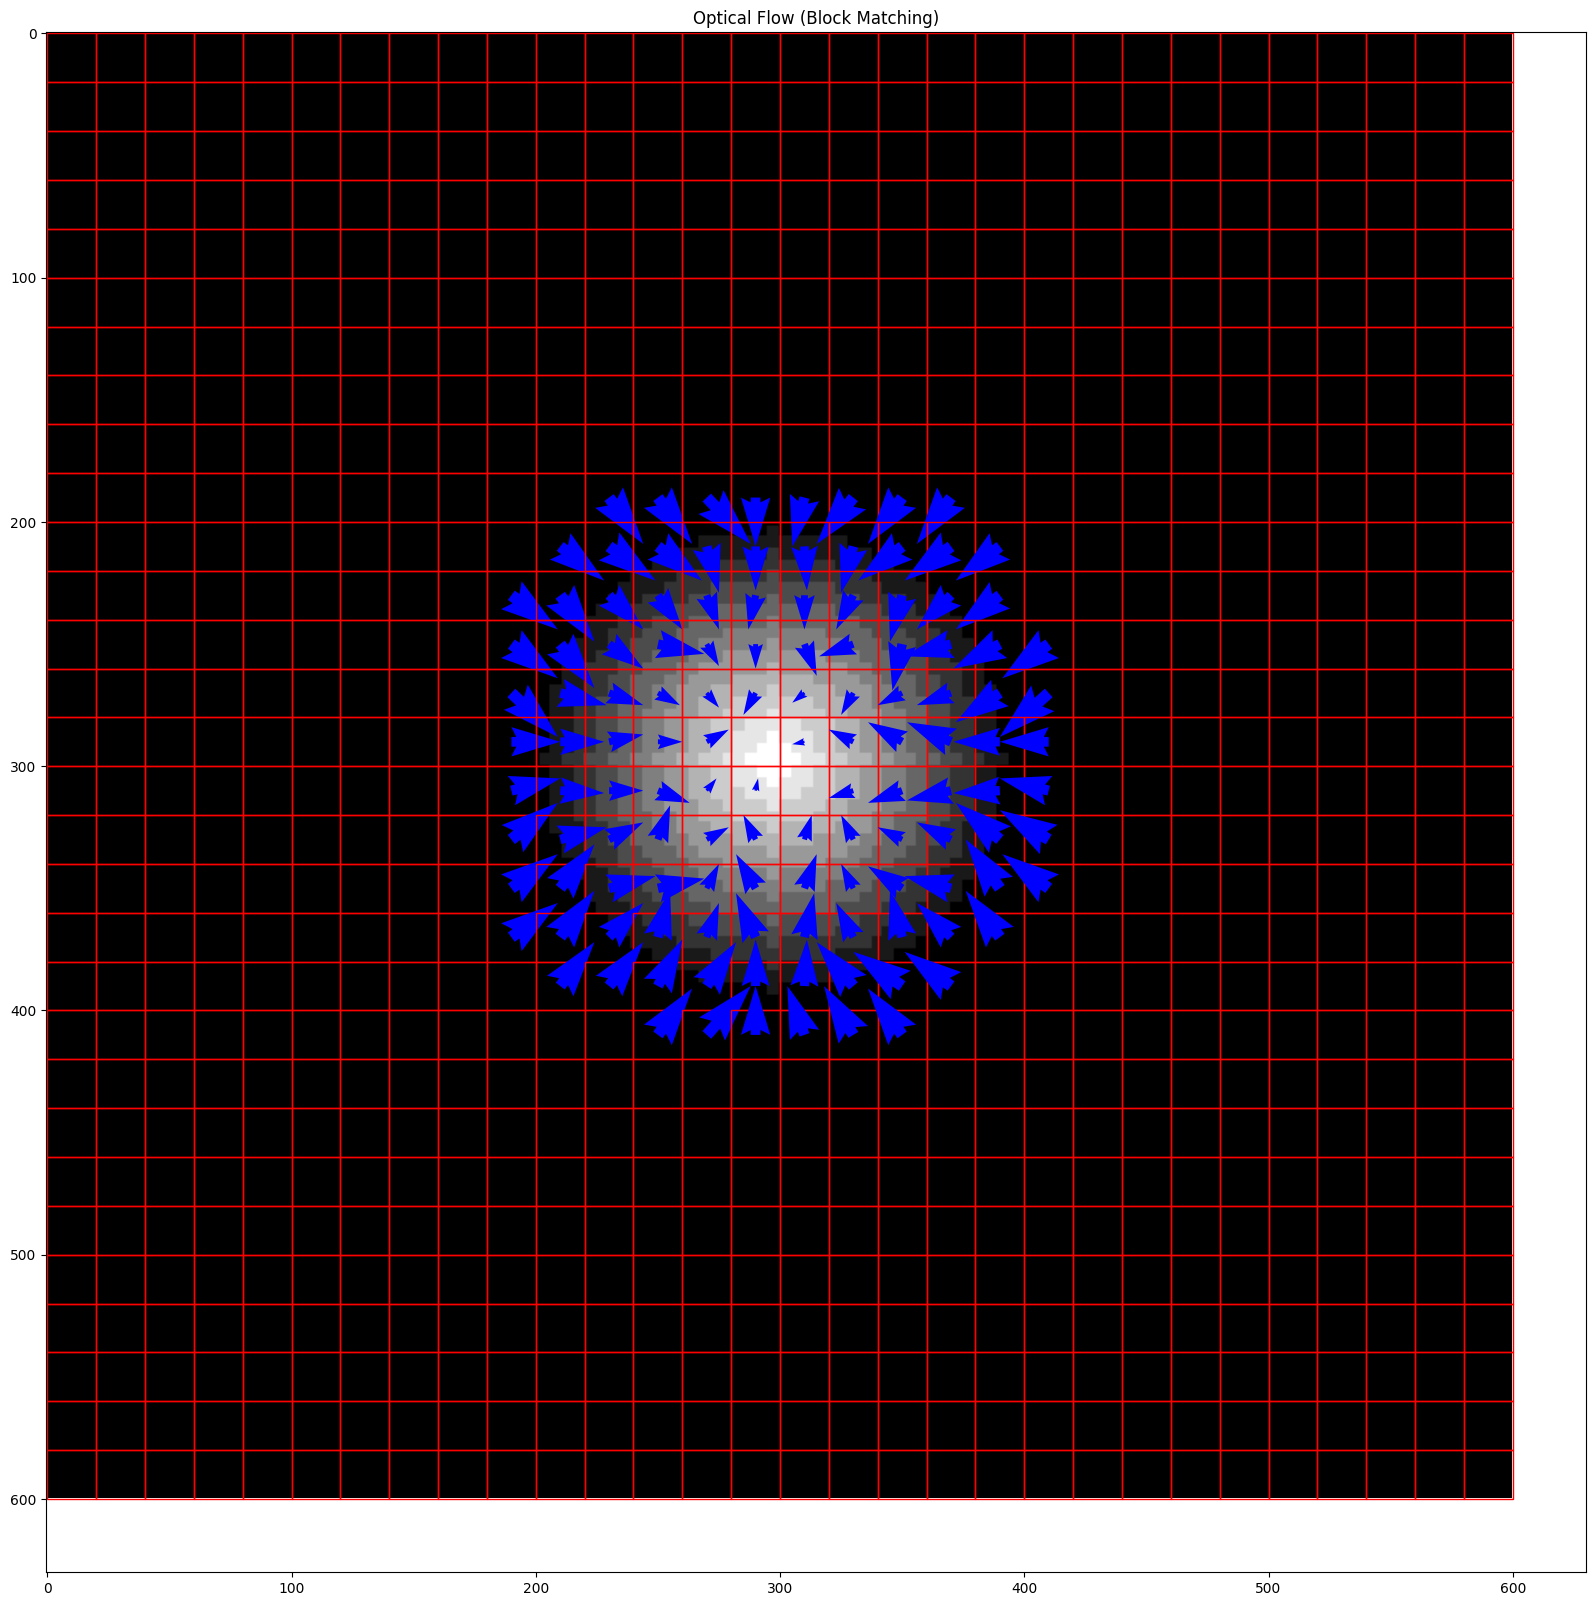

In [6]:
visualize_block_matching(img1, img2, block_size = 20)

Zoomons pour voir plus en détails:

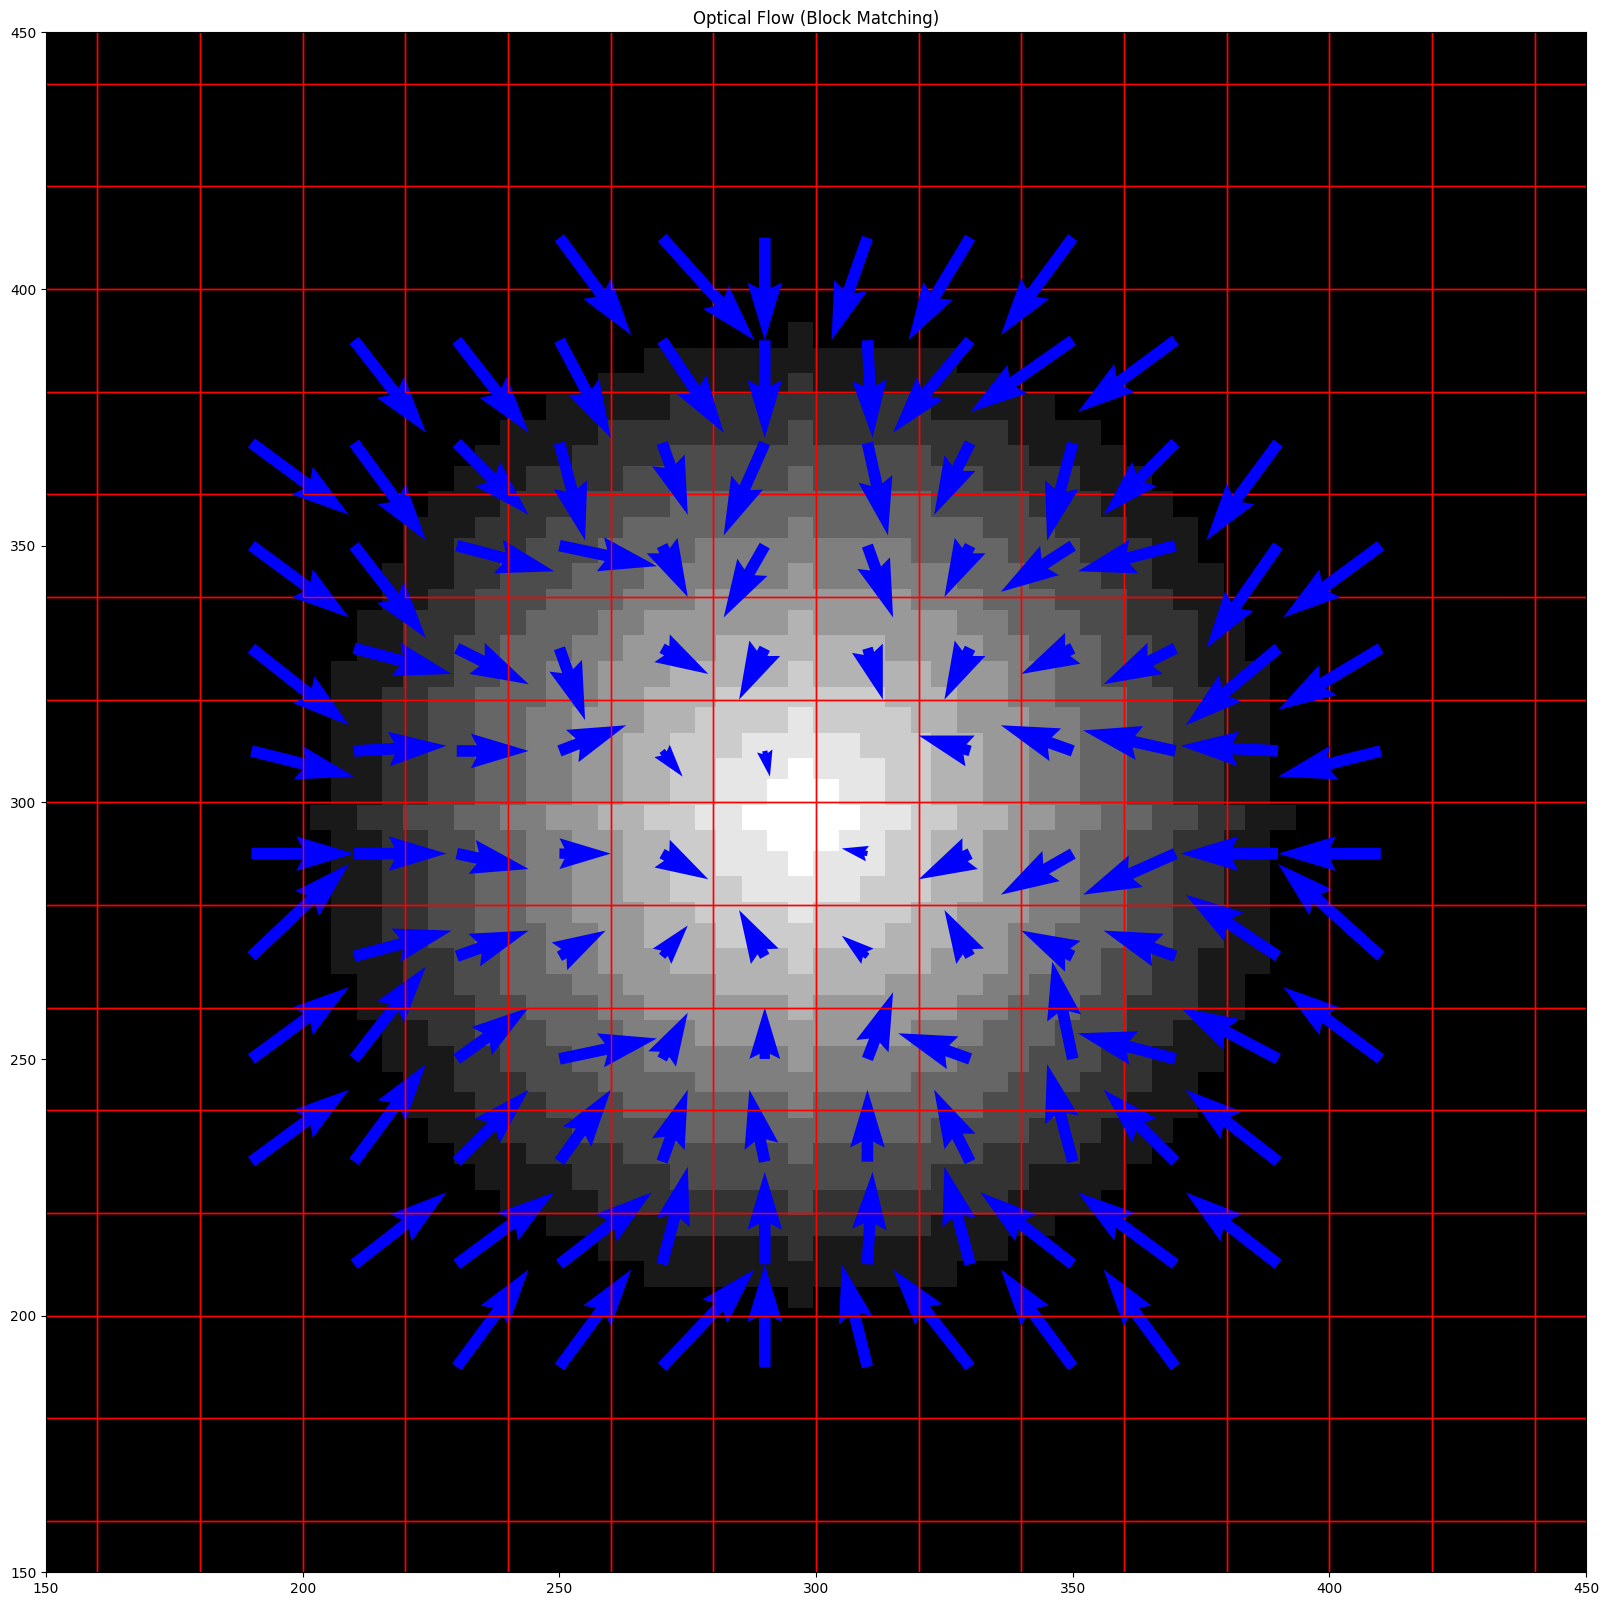

In [7]:
visualize_block_matching(img1, img2, block_size = 20, zoom=True)

En ajustant la taille des blocs et la fenêtre de recherche, il est possible de trouver un bon compromis entre précision et coût de calcul. Des blocs plus petits augmentent la précision mais nécessitent plus de calculs, tandis que des blocs plus grands réduisent le coût de calcul et peuvent être plus robustes aux variations locales mais par la même occasion manquer de précision.

### (B) Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)

### Artéfacts visuels en cas d'estimation de mouvement forward

Faire de l'estimation de mouvement backward permet de mieux gérer certains types d'artéfacts visuels qui peuvent survenir lors de la reconstruction d'une image. En effet, si on utilisait l'estimation de mouvement forward pour reconstruire F2 à partir de F1, on pourrait rencontrer les artéfacts visuels suivants :

1. **Trouble de l'image / Distorsions** : Si les blocs sont déplacés incorrectement en raison de la prédiction forward, cela peut entraîner un flou ou une image brouillée car les pixels ne sont pas alignés correctement.

2. **Trous** : Lorsque des objets se déplacent et révèlent des zones cachées dans F2, ces zones pourraient rester vides ou incorrectement remplies lors de la reconstruction par estimation forward. Cela créerait des trous visibles dans l'image.

3. **Bloques mal alignés** : La prédiction forward peut entraîner un mauvais alignement des blocs, surtout si le mouvement n'est pas uniforme ou contient des accélérations et des décélérations. Cela se traduirait par des lignes ou des bordures visibles entre les blocs, perturbant la continuité visuelle de l'image.

4. **Duplications** : Si un bloc est déplacé vers une nouvelle position en utilisant une estimation forward, il peut arriver que la position originale soit laissée vide, entraînant une duplication des pixels dans certaines zones de l'image.

En résumé, l'estimation de mouvement backward est utilisée pour reconstruire F2 à partir de F1 pour mieux gérer les occlusions, préserver la continuité spatiale et éviter les artéfacts visuels tels que les trous, le flou et les mauvais alignements.

### (C) Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

Pour reconstruire l'image $F2$ à partir de $F1$ et des vecteurs de mouvement, nous utilisons les vecteurs $(u,v)$ pour déplacer chaque bloc de $F1$ à la position correspondante dans $F2$.

**Algorithme de Correspondance de Blocs :**

1. **Division en Blocs :**
   L'image $ F1 $ est divisée en blocs non superposés de taille $ N \times N $.

2. **Reconstruction de F2 :**
   En utilisant les vecteurs de mouvement calculés $ (u,v) $, chaque bloc dans $ F1 $ est déplacé à la position correspondante dans $ F2 $ :
   $$
   F2(x, y) = F1(x + u, y + v)
   $$
   Cela donne l'image reconstruite $ \hat{F2} $.

4. **Erreur Quadratique Moyenne (MSE) :**
   La MSE entre l'image originale $ F2 $ et l'image reconstruite $ \hat{F2} $ est donnée par :
   $$
   \text{MSE} = \frac{1}{MN} \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} \left( F2(x, y) - \hat{F2}(x, y) \right)^2
   $$
   où $ M $ et $ N $ sont les dimensions de l'image.

In [8]:
def reconstruct_image(frame1, flow_u, flow_v, block_size=10):
    height, width = frame1.shape
    reconstructed_image = np.zeros_like(frame1)

    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            u = int(flow_u[i // block_size, j // block_size])
            v = int(flow_v[i // block_size, j // block_size])
            src_i = i + v
            src_j = j + u
            if 0 <= src_i < height - block_size and 0 <= src_j < width - block_size:
                reconstructed_image[i:i + block_size, j:j + block_size] = frame1[src_i:src_i + block_size, src_j:src_j + block_size]

    return reconstructed_image

In [9]:

block_size = 20
search_range = 20

flow_u, flow_v, modified_blocks = block_matching(img1, img2, block_size, search_range)

reconstructed_F2 = reconstruct_image(img1, flow_u, flow_v, block_size)

reconstruction_mse = mean_squared_error(img2, reconstructed_F2)
print(f'Reconstruction MSE: {reconstruction_mse}')

Reconstruction MSE: 0.00016815404562383062


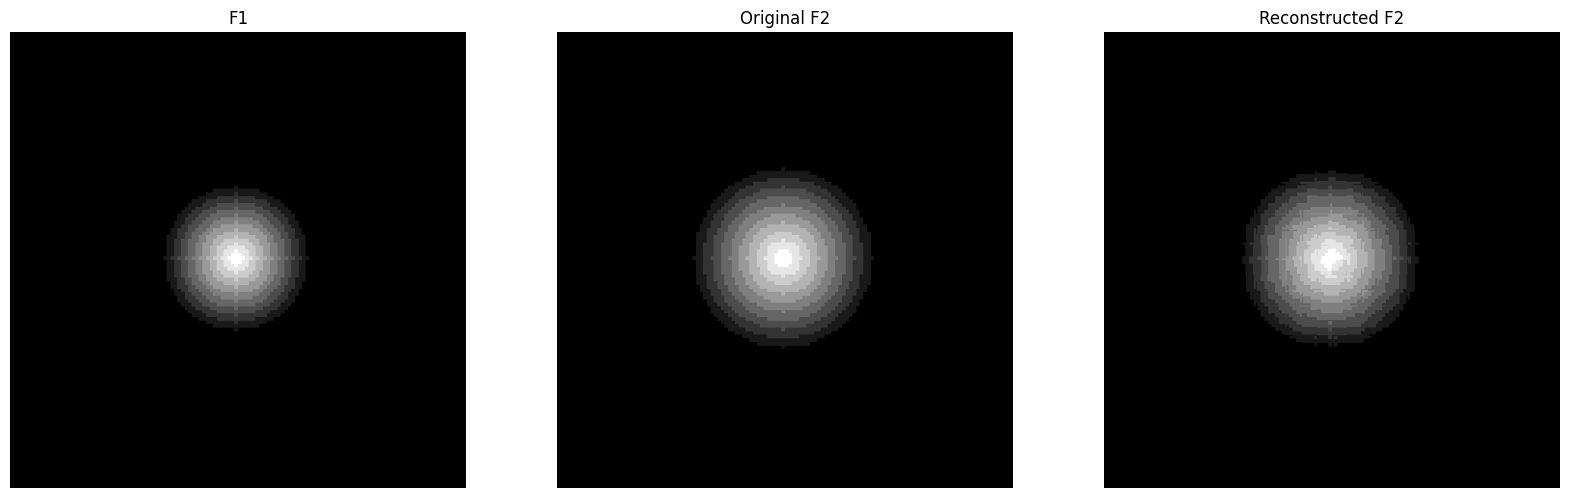

In [10]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title('F1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title('Original F2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_F2, cmap='gray')
plt.title('Reconstructed F2')
plt.axis('off')

plt.show()

L'image reconstruite $\hat{F2}$ ressemble étroitement à l'originale $F2$. Des différences semble apparaitre là où l'estimation de mouvement n'est pas parfaite. Par ailleurs, on remarque aussi un décallage au niveau de la quantisation. En effet, la valeur de la MSE qui quantifie la qualité de la reconstruction, n'est pas nulle (mais reste très faible pour autant, sachant qu'une MSE plus faible indique une meilleure reconstruction).

### (D) Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données "classiques" (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

Pour reconstruire l'image $F2$ de façon parfaite en utilisant la compensation de mouvement, nous avons besoin des données suivantes :

1. **Vecteurs de mouvement** : Ils indiquent la direction et la distance que chaque bloc doit parcourir pour passer de $F1$ à $F2$.
2. **Image de référence** : Utilisée comme base visuelle sur laquelle les mouvements seront appliqués.
3. **Erreur de prédiction** : La différence entre l'image prédite en appliquant les vecteurs de mouvement à $F1$ et l'image cible réelle $F2$. Cette information est cruciale pour compenser les erreurs qui se produisent après l'application des vecteurs de mouvement.

Cette approche assure que l'image F2 est reconstruite aussi précisément que possible en utilisant les informations transmises.

### (E) Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

Nous reconstruisons $F2$ en utilisant les vecteurs de mouvement quantifiés, l'image de référence $F1$, et l'erreur de prédiction quantifiée.

**Processus de Reconstruction :**

1. **Prédiction par Compensation de Mouvement :**
   Pour chaque bloc dans $ F1 $, nous utilisons les vecteurs de mouvement $ (u,v) $ pour prédire le bloc correspondant dans $ F2 $ :
   $$
   F2_{\text{préd}}(x, y) = F1(x + u, y + v)
   $$
   où $ F2_{\text{préd}}(x, y) $ est la valeur du pixel prédite dans $ F2 $ à la position $ (x, y) $.

2. **Calcul de l'Erreur de Prédiction :**
   L'erreur de prédiction $ \epsilon(x, y) $ est la différence entre $ F2 $ réel et le $ F2_{\text{préd}} $ prédit :
   $$
   \epsilon(x, y) = F2(x, y) - F2_{\text{préd}}(x, y)
   $$

3. **Reconstruction avec l'Erreur de Prédiction :**
   L'image finale reconstruite $ \hat{F2} $ est obtenue en ajoutant l'erreur de prédiction $ \epsilon $ au $ F2_{\text{préd}} $ prédit :
   $$
   \hat{F2}(x, y) = F2_{\text{préd}}(x, y) + \epsilon(x, y)
   $$

4. **Erreur Quadratique Moyenne (MSE) :**
   La MSE entre l'image originale $ F2 $ et l'image reconstruite $ \hat{F2} $ est calculée comme suit :
   $$
   \text{MSE} = \frac{1}{MN} \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} \left( F2(x, y) - \hat{F2}(x, y) \right)^2
   $$
   où $ M $ et $ N $ sont les dimensions de l'image.

In [11]:
def calculate_prediction_error(predicted_image, actual_image):
    return actual_image - predicted_image

def add_prediction_error(predicted_image, prediction_error):
    return predicted_image + prediction_error

block_size = 20
search_range = 20

flow_u, flow_v, modified_blocks = block_matching(img1, img2, block_size, search_range)
predicted_F2 = reconstruct_image(img1, flow_u, flow_v, block_size)

# Calculate the prediction error and reconstruct the final F2
prediction_error = calculate_prediction_error(predicted_F2, img2)
reconstructed_F2_final = add_prediction_error(predicted_F2, prediction_error)

reconstruction_mse = mean_squared_error(img2, reconstructed_F2_final)
print(f'Reconstruction MSE: {reconstruction_mse}')

Reconstruction MSE: 0.0


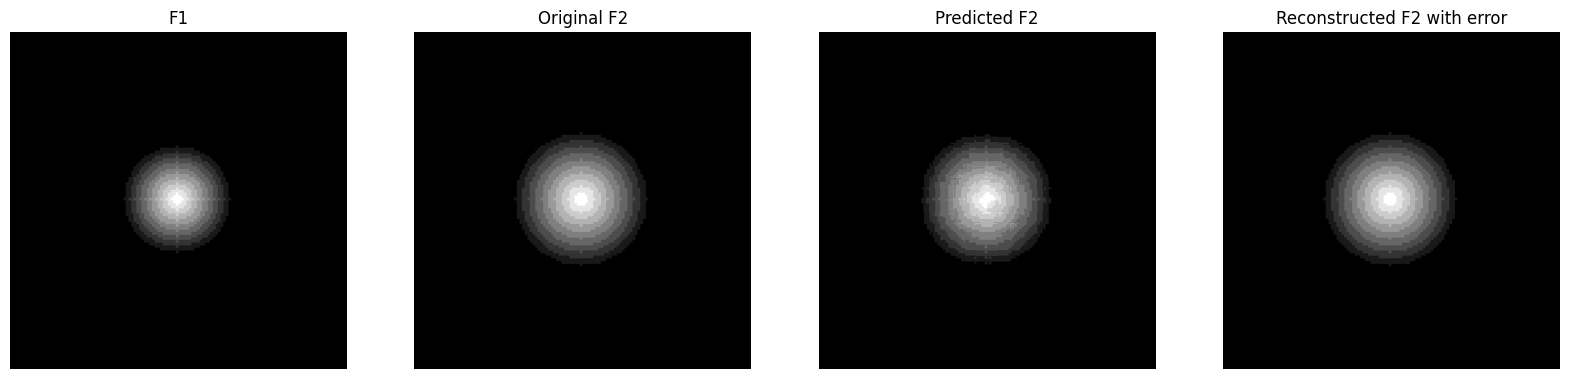

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(img1, cmap='gray')
plt.title('F1')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img2, cmap='gray')
plt.title('Original F2')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(predicted_F2, cmap='gray')
plt.title('Predicted F2')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(reconstructed_F2_final, cmap='gray')
plt.title('Reconstructed F2 with error')
plt.axis('off')

plt.show()

On remarque que la reconstruction avec l'erreur fonctionne parfaitement. En effet, visuellement comme quantitativement avec la valeur de la MSE (qui est nulle), nous pouvons dire que la reconstruction est égale à la cible $F2$.

### (F) Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 "correcte". Justifiez vos explications par des images de rendus.

Il est possible de quantifier certaines parties des informations transmises avec une perte minimale de qualité, en quantifiant :

1. **Vecteurs de Mouvement** : Les vecteurs de mouvement peuvent être quantifiés en arrondissant les valeurs résultantes. Cela réduit la précision des vecteurs de mouvement mais ça reste acceptable.

Les vecteurs de mouvement $(u,v)$ sont quantifiés de cette façon:
   $$
   u_{\text{quant}} = \left\lfloor u \right\rfloor
   $$
   $$
   v_{\text{quant}} = \left\lfloor u \right\rfloor
   $$

2. **Erreur de Prédiction** : Cette erreur peut également être quantifiée de la même manière pour réduire la quantité de données.

   L'erreur de prédiction $\epsilon(x, y)$ est également quantifiée:
   $$
   \epsilon_{\text{quant}}(x, y) = \left\lfloor \epsilon(x, y) \right\rfloor
   $$

En effet, un entier pourra maintenant prendre moins de place en mémoire qu'un float.
Une quantification en utilisant la méthode utilisée par le format jpeg pourrait aussi être utilisée et serait beacoup plus efficace mais ne semble pas rentrer dans le cadre de ce cours donc ce n'est surement pas la méthode que vous attendez.


In [13]:
def quantize_motion_vectors(flow_u, flow_v):
    return (flow_u).astype(int), (flow_v).astype(int)

def quantize_prediction_error(prediction_error):
    return prediction_error.astype(int)

# Reconstruction de l'image prédite F2 avec les vecteurs de mouvement quantifiés
quantized_flow_u, quantized_flow_v = quantize_motion_vectors(flow_u, flow_v)
predicted_F2_quantized = reconstruct_image(img1, quantized_flow_u, quantized_flow_v, block_size)

# Reconstruction finale de F2 avec l'erreur de prédiction quantifiée
quantized_prediction_error = quantize_prediction_error(predicted_F2_quantized - img2)
reconstructed_F2_quantized = predicted_F2_quantized + quantized_prediction_error

reconstruction_mse_quantized = mean_squared_error(img2, reconstructed_F2_quantized)
print(f'Reconstruction MSE with quantization: {reconstruction_mse_quantized}')

Reconstruction MSE with quantization: 0.00016815404524273388


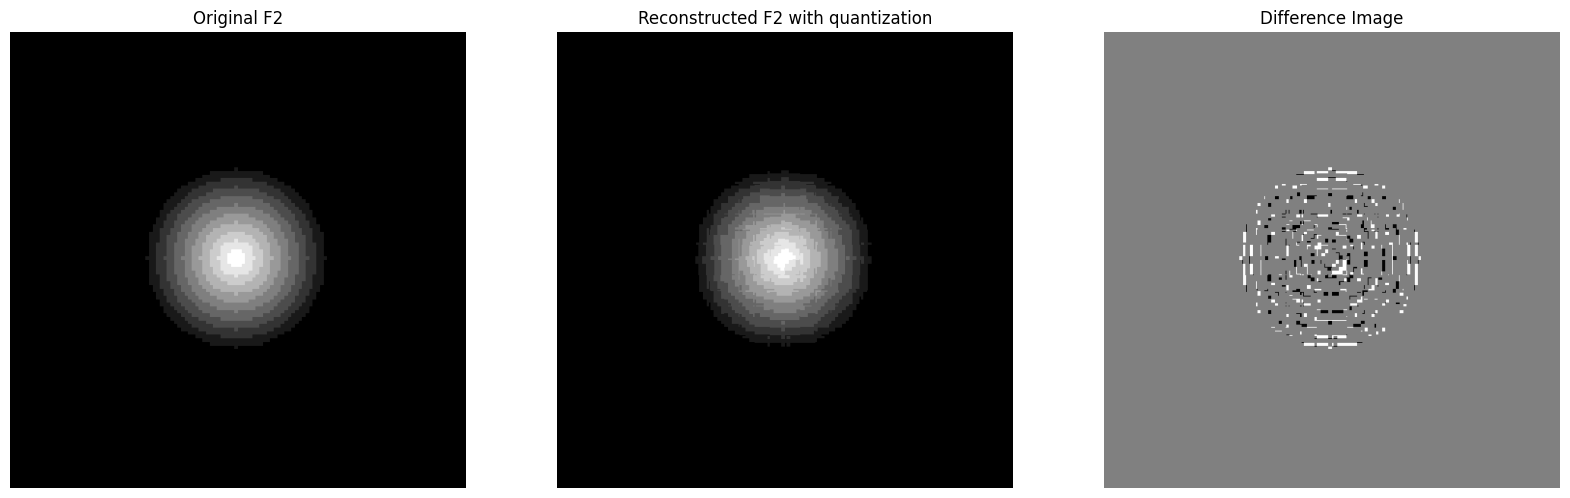

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(img2, cmap='gray')
plt.title('Original F2')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_F2_quantized, cmap='gray')
plt.title('Reconstructed F2 with quantization')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img2 - reconstructed_F2_quantized, cmap='gray')
plt.title('Difference Image')
plt.axis('off')

plt.show()

Il y a en visuellement un peu de perte mais l'image reste reconnaissable.